# GROBID evaluation

This notebook is used to evaluate the accuracy of GROBID's affiliation parsing capabilities. It compares the predictions of the GROBID API with the ground truth author and affiliation data, along with predictions made using other strategies.

Ground truth authors and affiliations were cataloged by hand using SHROOM, and are downloaded as Cocina from SDR by the `preprints:download` task (see README.md). This needs to be run prior to running this notebook.

Article plain texts are extracted from the PDFs using the `preprints:clean` task (see README.md). This also needs to be run prior to running this notebook.

A GROBID server needs to be running locally and available at port 8070 to make the predictions. On an ARM64 Mac, you can do this using Docker with:
```sh
docker run --rm --init --ulimit core=0 -p 8070:8070 --platform linux/amd64 lfoppiano/grobid:latest-crf
```

If predictions have already been saved to the `output/grobid` folder, those will be loaded and used instead.

In [14]:
# set up project root path for imports
import sys
import os
import pathlib
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PROJECT_ROOT = pathlib.Path(root)

# make scripts in scripts/ importable and import util functions
sys.path.insert(1, str(PROJECT_ROOT / 'scripts'))
from notebook_utils import get_gold_affiliations, get_preprint_text

# set up data table with columns for gold and predicted affiliations
import pandas as pd
preprints = pd.read_csv(PROJECT_ROOT / 'assets' / 'preprints.csv')
preprints['gold'] = ''
preprints['pred'] = ''

# add the gold affiliations, file, and text to the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    preprint_file = PROJECT_ROOT / "assets" / "preprints" / "pdf" / f"{preprint_id}.pdf"
    preprints.at[i, 'file'] = preprint_file
    preprints.at[i, 'text'] = get_preprint_text(preprint_id)
    preprints.at[i, 'gold'] = get_gold_affiliations(preprint_id)

# limit to only rows where we have gold affiliations
preprints = preprints[preprints['gold'] != '']
print("loaded gold affiliations for", len(preprints), "preprints")

loaded gold affiliations for 100 preprints


In [15]:
from notebook_utils import RESULTS_PATH, get_grobid_prediction, load_predictions_xml
from tqdm.notebook import tqdm

# set this and run cell to force re-running predictions
FORCE_RERUN = False

# if we don't have any saved predictions, run prediction for every preprint
grobid_results_path = RESULTS_PATH / "grobid"
predictions = load_predictions_xml(grobid_results_path)
if not predictions or FORCE_RERUN:
    print("No predictions found, running prediction for all preprints")
    for i, row in tqdm(preprints.iterrows(), total=len(preprints), desc="Predicting"):
        preprint_file = row['file']
        get_grobid_prediction(preprint_file, grobid_results_path)
    predictions = load_predictions_xml(grobid_results_path)
else:
    print("Using saved predictions")

# set predictions for each preprint in the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    if preprint_id in predictions:
        preprints.at[i, 'pred'] = predictions[preprint_id]
print("loaded predictions for", len(preprints), "preprints")

Using saved predictions
loaded predictions for 100 preprints


# Author detection

Let's evaluate GROBID-CRF's author detection capabilities. We will compare the predictions made by GROBID with the ground truth authors.

We use two different metrics for accuracy:
- "Lev list" is scored by the averaged levenshtein ratio of each author in the list of ground truth authors, compared pairwise in order with the predicted authors. This means that the order of the authors matters; if the predicted authors are in a different order or are missing one of the first few authors, the score will be substantially lower.
- "Lev combined" is scored the levenshtein ratio of the two lists of authors joined together as a single string. This means that the order of the authors matters less than whether all authors are present; a lower score indicates more human intervention needed to correct the list.

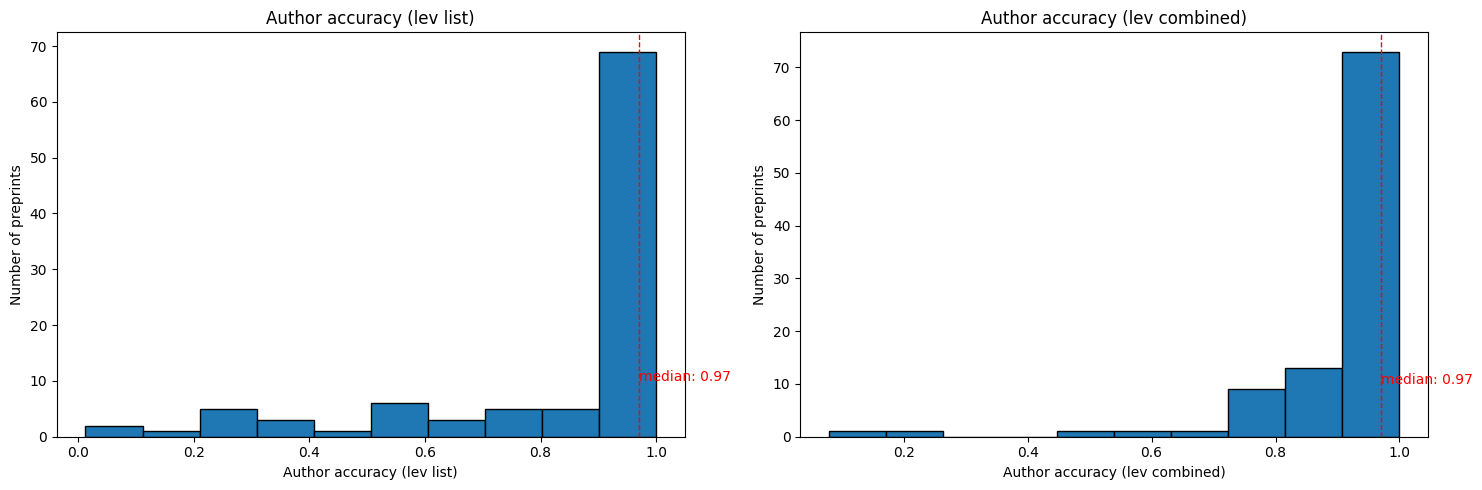

In [16]:
from utils import lev_ratio_list, lev_ratio_combined_list

# calculate some accuracy statistics for authors
for i, row in preprints.iterrows():
    gold_authors = list(row['gold'].keys())
    pred_authors = list(row['pred'].keys())
    preprints.at[i, 'authors_accuracy_lev_list'] = lev_ratio_list(gold_authors, pred_authors)
    preprints.at[i, 'authors_accuracy_lev_combined'] = lev_ratio_combined_list(gold_authors, pred_authors)

# print side-by-side histograms of author accuracy, using the two different score types
# also render the median as a vertical line
%matplotlib inline
import matplotlib.pyplot as plt
author_acc_lev_list = preprints['authors_accuracy_lev_list']
author_acc_lev_combined = preprints['authors_accuracy_lev_combined']
author_acc_lev_list_median = author_acc_lev_list.median()
author_acc_lev_combined_median = author_acc_lev_combined.median()

plt.figure(figsize=(15, 5))

lev_list_plt = plt.subplot(1, 2, 1)
lev_list_plt.hist(author_acc_lev_list, edgecolor='black')
lev_list_plt.set_xlabel('Author accuracy (lev list)')
lev_list_plt.set_ylabel('Number of preprints')
lev_list_plt.set_title('Author accuracy (lev list)')
lev_list_plt.axvline(author_acc_lev_list_median, color='r', linestyle='dashed', linewidth=1)
lev_list_plt.text(author_acc_lev_list_median, 10, f'median: {author_acc_lev_list_median:.2f}', color='r')

lev_combined_plt = plt.subplot(1, 2, 2)
lev_combined_plt.hist(author_acc_lev_combined, edgecolor='black')
lev_combined_plt.set_xlabel('Author accuracy (lev combined)')
lev_combined_plt.set_ylabel('Number of preprints')
lev_combined_plt.set_title('Author accuracy (lev combined)')
lev_combined_plt.axvline(author_acc_lev_combined_median, color='r', linestyle='dashed', linewidth=1)
lev_combined_plt.text(author_acc_lev_combined_median, 10, f'median: {author_acc_lev_combined_median:.2f}', color='r')

plt.tight_layout()
plt.show()

# Author detection issues

What are the common issues with author detection? We will look at the most common issues with author detection, and how they can be resolved. We start by examining some of the preprints that scored the lowest in the "lev combined" metric.

The errors here come in a few flavors:

- Additional authors: GROBID adds names to the list of authors that are not present in the ground truth (e.g. W2919371474, W4205859241). This seems to be the most common error.
- Non-authors: GROBID identifies items as authors that are not people (e.g. W3000588783, W2942725897). This can include phrases like "Orcid ID", "Professor", "American Bar Foundation", and other terms.
- Missing authors: GROBID misses some authors in the list (e.g. W3174220540). This seems rare.

An additional issue is GROBID neglecting to remove titles and other information from authors' names, leading to slightly different formatting than the ground truth (e.g. leaving the "PhD" in "John Doe, PhD"). Because of our levenshtein distance metric, this can lead to a slightly lower score, but has far less of an impact than the above issues (only a few characters of difference).


In [17]:
# for the preprints with the lowest author accuracy, print the gold and predicted affiliations
worst_preprints = preprints.sort_values(by='authors_accuracy_lev_combined').head(10)
for i, row in worst_preprints.iterrows():
    print(f"{row['OpenAlex ID']} ({row['OpenAlex Title']})")
    print("Authors accuracy:", row['authors_accuracy_lev_combined'])
    print("Gold:", list(row['gold'].keys()))
    print("Pred:", list(row['pred'].keys()))
    print()

W3000588783 (An International Multicenter Evaluation of Type 5 Long QT Syndrome)
Authors accuracy: 0.0788461538461539
Gold: ['Jason D. Roberts', 'S. Yukiko Asaki', 'Andrea Mazzanti', 'J. Martijn Bos', 'Izabella Tuleta', 'Alison R. Muir', 'Lia Crotti', 'Andrew D. Krahn', 'Valentina Kutyifa', 'M. Benjamin Shoemaker', 'Christopher L. Johnsrude', 'Takeshi Aiba', 'Luciana Marcondes', 'Anwar Baban', 'Sharmila Udupa', 'Brynn Dechert', 'Peter Fischbach', 'Linda M. Knight', 'Eric Vittinghoff', 'Deni Kukavica', 'Birgit Stallmeyer', 'John R. Giudicessi', 'Carla Spazzolini', 'Keiko Shimamoto', 'Rafik Tadros', 'Julia Cadrin-Tourigny', 'Henry J. Duff', 'Christopher S. Simpson', 'Thomas M. Roston', 'Yanushi D. Wijeyeratne', 'Imane El Hajjaji', 'Maisoon D. Yousif', 'Lorne J. Gula', 'Peter Leong-Sit', 'Nikhil Chavali', 'Andrew P. Landstrom', 'Gregory M. Marcus', 'Sven Dittmann', 'Arthur A. M. Wilde', 'Elijah R. Behr', 'Jacob Tfelt-Hansen', 'Melvin M. Scheinman', 'Marco V. Perez', 'Juan Pablo Kaski', 'R

What triggers these issues to present? Let's try to identify features shared by the preprints with the lowest scores in the "lev combined" metric.

The overall length of the preprint, number of authors, and number of affiliations don't seem to have any correlation with GROBID's accuracy.

Two features that do have a significant impact are those that move full author/affiliation info to a separate section, resulting in authors not being identified (e.g. W3000588783) and the presence of person-heavy acknowledgement sections that are identified as authors (W2919371474, W4205859241, W3147817170, 0.4626865671641791). Preprints with these features had accuracy scores below 60% and require significant intervention to correct.

Other features with a slight impact are authors whose names include titles or are formatted slightly differently (e.g. W2942725897, W2890142544, W2942725897) and cases where the same author is listed twice, but in an abbreviated form later (W4232006839, W4245851024). Preprints with these features scored better than those with more significant issues because they require less human intervention to correct.

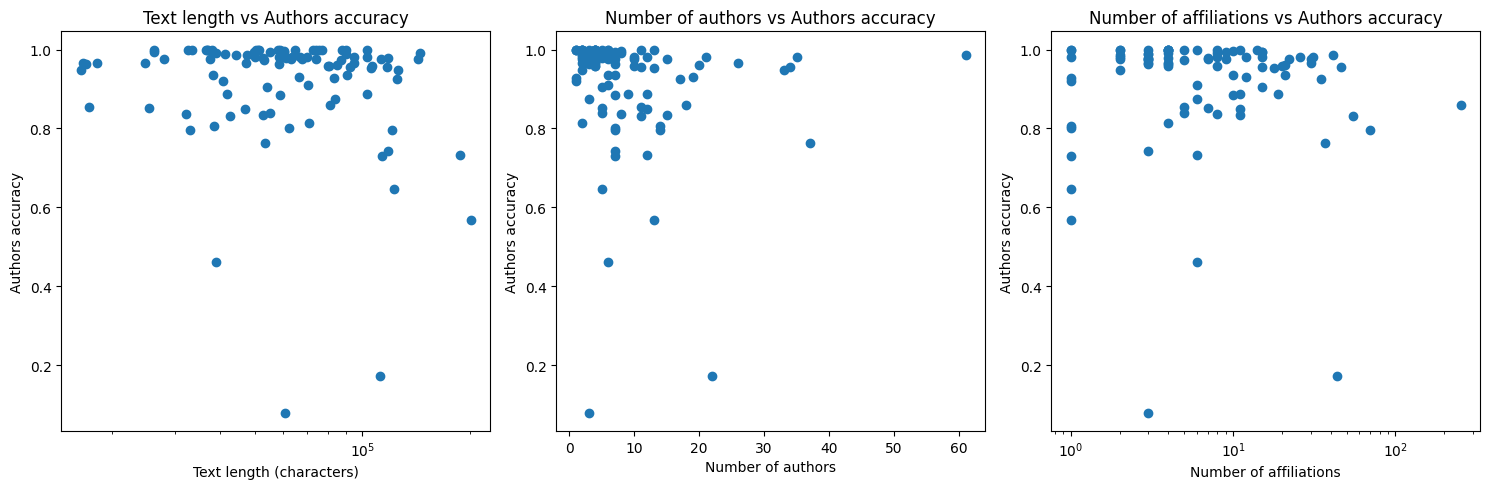

In [18]:
# add columns for length, number of authors and number of affiliations
preprints['length'] = preprints['text'].apply(len)
preprints['num_authors'] = preprints['pred'].apply(len)
preprints['num_affiliations'] = preprints['pred'].apply(lambda x: sum(len(v) for v in x.values()))

# plot the length, number of authors, and number of affiliations for each preprint
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(preprints['length'], preprints['authors_accuracy_lev_combined'])
plt.xlabel('Text length (characters)')
plt.ylabel('Authors accuracy')
plt.xscale('log')
plt.title('Text length vs Authors accuracy')
plt.subplot(1, 3, 2)
plt.scatter(preprints['num_authors'], preprints['authors_accuracy_lev_combined'])
plt.xlabel('Number of authors')
plt.ylabel('Authors accuracy')
plt.title('Number of authors vs Authors accuracy')
plt.subplot(1, 3, 3)
plt.scatter(preprints['num_affiliations'], preprints['authors_accuracy_lev_combined'])
plt.xlabel('Number of affiliations')
plt.ylabel('Authors accuracy')
plt.xscale('log')
plt.title('Number of affiliations vs Authors accuracy')
plt.tight_layout()
plt.show()


# Affiliation detection

Let's turn our attention to affiliations. Bearing in mind that missing authors will necessarily mean missing affiliations, let's see how GROBID-CRF performs on affiliation detection.

We use a single metric for accuracy: the levenshtein ratio of the two *sorted* lists of affiliations, averaged over all authors in the document. This means that the order of affiliations should matter very little; the most important thing is that all affiliations are present (unlike with authors, where the order has an implied importance).

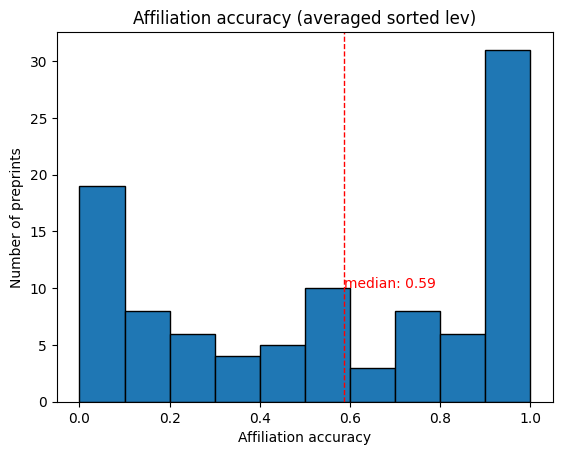

In [19]:
import statistics

# calculate some accuracy statistics for affiliations
# affiliation accuracy is the mean of the lev ratio of each author's affiliations lists
for i, row in preprints.iterrows():
    preprints.at[i, 'affiliations_accuracy'] = statistics.mean([
        lev_ratio_list(sorted(gold), sorted(pred)) for gold, pred in zip(row['gold'].values(), row['pred'].values())
    ])

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
affil_acc = preprints['affiliations_accuracy']
affil_acc_median = affil_acc.median()
plt.hist(affil_acc, edgecolor='black')
plt.xlabel('Affiliation accuracy')
plt.ylabel('Number of preprints')
plt.title('Affiliation accuracy (averaged sorted lev)')
plt.axvline(affil_acc_median, color='r', linestyle='dashed', linewidth=1)
plt.text(affil_acc_median, 10, f'median: {affil_acc_median:.2f}', color='r')
plt.show()


# Affiliation detection issues

Our data here shows a clear split between preprints with a very high accuracy score and those with a very low accuracy score. What is going wrong in the latter group?

Examining the preprints that scored poorly shows an issue common to all of them: no or almost no affiliations are being predicted by GROBID. Why might this be?

Again, the issue does not have to do with the overall length of the preprint, number of authors, or number of affiliations. Instead, the issues seem to be with the formatting of the affiliations themselves.

One problem is familiar and also affects author detection – the case where all authors and affiliations are not presented together, sequentially, at the beginning of the document. Of the ten lowest-scoring preprints, three have this issue (W3178821884, W4226047880, W2941345678). This can range from an "et al." or "see end of article" note, to a front page where the authors are listed and affiliations are relegated to a footnote that occurs after several paragraphs of body text.

The other problem is unique to affiliations. GROBID's parsing model seems to be tuned to handle "keyed" affiliations, where each author is followed by a superscript indicator that matches it to an affiliation. Of the ten lowest-scoring preprints, six have affiliations that are *not* written this way (W2942725897, W2963628635, W3147817170, W3116436840, W3199353954, W4399283731). Instead, affiliations may simply follow the names in running text, or even be written as natural language sentences.

In [21]:
# for the preprints with the lowest affiliation accuracy, print the gold and predicted affiliations
worst_preprints = preprints.sort_values(by='affiliations_accuracy').head(10)
for i, row in worst_preprints.iterrows():
    print(f"{row['OpenAlex ID']} ({row['OpenAlex Title']})")
    print("Affiliations accuracy:", row['affiliations_accuracy'])
    print("Gold:", list(row['gold'].values()))
    print("Pred:", list(row['pred'].values()))
    print()

W2942725897 (Emotion Regulation in Achievement Situations: An Integrated Model)
Affiliations accuracy: 0.0
Gold: [['University of Alberta'], ['University of Munich', 'Australian Catholic University'], ['Stanford University'], ['Stanford University']]
Pred: [[], [], [], [], [], [], ['Stanford University']]

W2941345678 (Current Challenges and Future Trends in Analytical Fragility and Vulnerability Modeling)
Affiliations accuracy: 0.0
Gold: [['Global Earthquake Model Foundation'], ['Bogazici University'], ['Stanford University'], ['University School for Advanced Studies IUSS Pavia'], ['University of Porto'], ['EUCENTRE'], ['University of Ljubljana'], ['University College of London'], ['University of Genoa'], ['University School for Advanced Studies IUSS Pavia'], ['University School for Advanced Studies IUSS Pavia'], ['University of Thessaloniki'], ['National Technical University of Athens']]
Pred: [[], [], [], [], [], [], [], [], [], [], [], [], []]

W2976790204 (SHARP UPPER BOUNDS FOR F

# 